# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from keras.src.optimizers import Adam



## Data Preparation

In [2]:
# Beispiel Daten laden
data = pd.read_csv('./../Data/preprocessed_df.csv') # Pfad zu Ihren Daten

print(data.head())

# Daten skalieren
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# GAN-Parameter
latent_dim = 100
data_dim = data_scaled.shape[1]

   participant_id  test_id  test_duration  mental  physical  temporal  \
0               1        1      33.643950      10         5        15   
1               1        2      28.484322      50        30        25   
2               1        3      71.423823     100        10        75   
3               1        4      38.163442      60        15        45   
4               2        1      41.748047      20        10        20   

   performance  effort  frustration  mean  mean_pupil_diameter  \
0           25      25           10  15.0            43.855534   
1           50      15           25  32.5            42.935538   
2           80      90           20  62.5            44.704459   
3           50      20           25  35.8            45.762156   
4           10      20           15  15.8            31.492393   

   median_pupil_diameter  blinkrate  fixationrate  
0              43.893976   0.059446      0.295946  
1              43.021599        NaN      0.175533  
2       

## GAN Definition

In [3]:
# Generator-Modell
def build_generator(latent_dim, data_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(data_dim, activation='tanh'))
    return model


## Discriminator Definition

In [4]:
def build_discriminator(data_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Build Model

In [5]:
# GAN-Modell
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
# Modelle erstellen

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Trainingsdaten
real = data_scaled
real_labels = np.ones((real.shape[0], 1))
fake_labels = np.zeros((real.shape[0], 1))

/Users/hennerbendig/anaconda3/envs/tf_311/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-13 07:39:19.238949: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-13 07:39:19.238967: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-13 07:39:19.238972: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-13 07:39:19.238987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 07:39:19.238998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

## Training

In [7]:
# GAN-Training
epochs = 1
batch_size = 32

d_losses = []
g_losses = []

for epoch in range(epochs):
    # Zufällige Samples von realen Daten
    idx = np.random.randint(0, real.shape[0], batch_size)
    real_samples = real[idx]
    
    # Zufälliges Rauschen und Fake-Daten generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)
    
    # Diskriminator trainieren
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels[:batch_size])
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels[:batch_size])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # GAN trainieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels[:batch_size])
    
    # Verluste speichern
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    # Fortschritt ausgeben
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

print("Training abgeschlossen!")
print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


2024-06-13 07:39:25.329966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/hennerbendig/anaconda3/envs/tf_311/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: nan, acc.: 78.90625%] [G loss: [array(nan, dtype=float32), array(nan, dtype=float32), array(0.796875, dtype=float32)]]


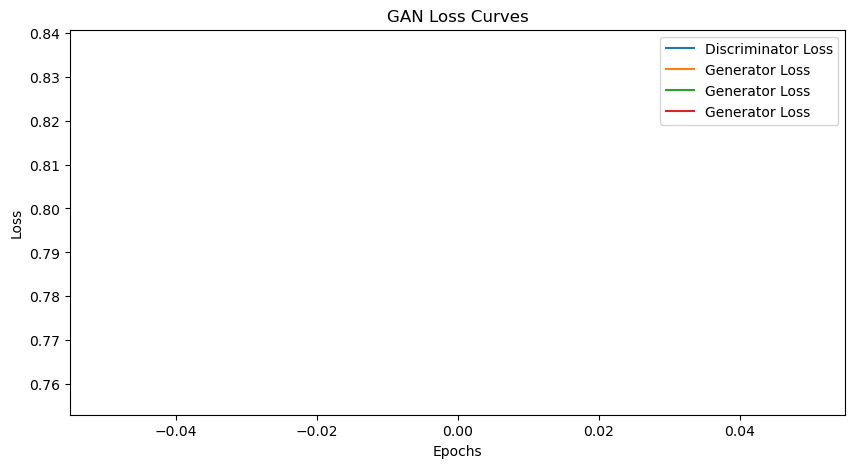

In [8]:
# Verlustkurven plotten
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

## Daten generieren

In [9]:
# Generieren von zusätzlichen Datenpunkten nach dem Training
num_additional_points = 1000
noise = np.random.normal(0, 1, (num_additional_points, latent_dim))
synthetic_data_scaled = generator.predict(noise)

# Die generierten Daten zurückskalieren auf den ursprünglichen Wertebereich
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)

# Die generierten Daten mit den Originaldaten kombinieren
augmented_data = np.vstack((data, synthetic_data))

# Optional: Konvertieren Sie die Daten in ein TensorFlow-Dataset
dataset = tf.data.Dataset.from_tensor_slices(augmented_data)

print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data.shape)
print("Augmented Data Shape:", augmented_data.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Original Data Shape: (188, 14)
Synthetic Data Shape: (1000, 14)
Augmented Data Shape: (1188, 14)


In [10]:
# Ausgewählte Datenpunkte plotten
print("Synthetic Data")
print(synthetic_data[:5])

Synthetic Data
[[-4.4375235e-01  1.6034615e+00 -1.2599918e+03 -1.4550791e+01
   2.6452831e+01  2.9868013e+01  3.0551684e+00  5.4615178e+00
   1.0252921e+01  1.4657219e+01  3.5360424e+01  2.8463026e+01
   3.8549128e-01  2.7204064e-01]
 [ 9.6131563e+00  1.1193528e+00 -1.0693342e+03  2.2834955e+01
   4.2511940e-01  1.0989278e+01  2.2673769e+01  5.2838142e+01
   1.3985216e+01  1.5282511e+01  2.4976017e+01  2.7091160e+01
   3.5968432e-01  2.0597021e-01]
 [ 1.7646656e+01  6.5197265e-01 -5.8650201e+02 -2.5140510e+00
   5.1028843e+01 -2.9106188e+01 -3.5688703e+00  2.1418274e+01
   2.4742012e+01  7.8190022e+00  2.3937792e+01  2.2747799e+01
   3.3529890e-01  3.7950810e-02]
 [ 2.7585300e+01  5.1078176e-01  1.3582703e+03 -9.7978687e+00
   4.4650906e+01 -3.1180117e+01 -1.6967079e+01  2.7742748e+01
   1.2720315e+01  3.2599663e+01  2.6530306e+01  2.8851955e+01
   2.7972469e-01  8.3033115e-02]
 [ 1.8284166e+01 -1.5052059e-01 -1.1712594e+03  2.2502325e+00
   3.2187458e+01 -2.5837903e+00  2.4984058e+01 